In [51]:
%load_ext autoreload
%autoreload 2

from configs.RecursiveVPSDE.LSTM_3DLorenz.recursive_LSTM_3DLorenzWithPosition_T256_H05_tl_5data import get_config
#from configs.RecursiveVPSDE.LSTM_3DLorenz.recursive_LSTM_PostMeanScaledScore_3DLorenz_T256_H05_tl_5data import get_config
#from configs.RecursiveVPSDE.LSTM_3DLorenz.recursive_LSTM_PostMeanScore_3DLorenz_T256_H05_tl_5data import get_config

from configs import project_config
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


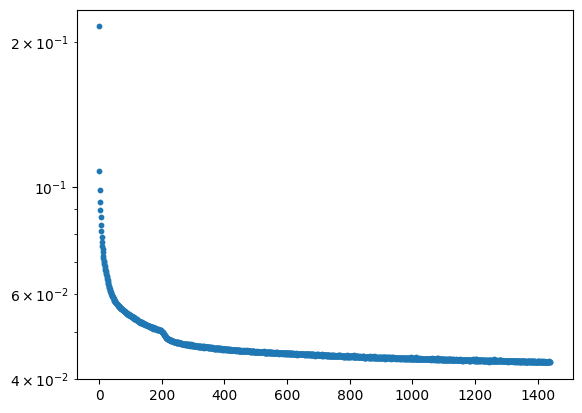

In [68]:
import pickle
filepath = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/training_losses/trained_rec_markv_TSMWP_False_incs_True_unitIntv_3DLnz_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin00000e+00_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_tl5_loss"
with open(filepath,'rb') as fp:
    losses = np.array(pickle.load(fp))
plt.scatter(np.arange(losses.shape[0]), losses, s=10)
plt.yscale("log")

1423


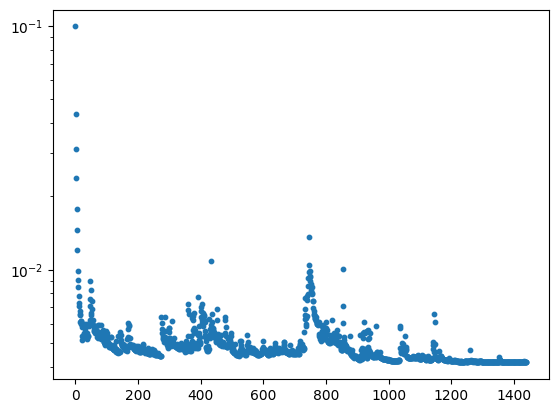

In [76]:
import pickle
filepath = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/training_losses/trained_rec_PM_TSM_False_incs_True_unitIntv_3DLnz_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin00000e+00_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_tl5_loss"
with open(filepath,'rb') as fp:
    losses = np.array(pickle.load(fp))
plt.scatter(np.arange(losses.shape[0]), losses, s=10)
plt.yscale("log")
print(np.argmin(losses))

1027


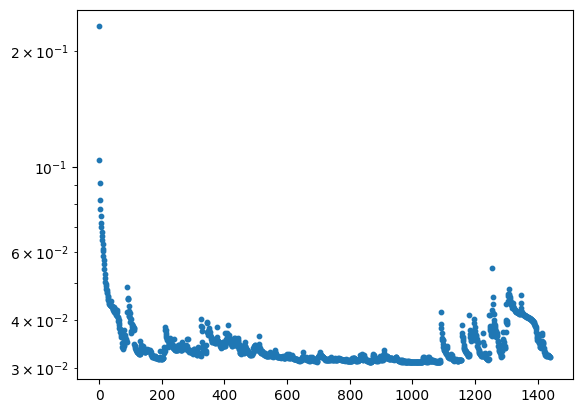

In [77]:
import pickle
filepath = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/training_losses/trained_rec_TSMWP_False_incs_True_unitIntv_3DLnz_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin00000e+00_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_tl5_loss"
with open(filepath,'rb') as fp:
    losses = np.array(pickle.load(fp))
plt.scatter(np.arange(losses.shape[0]), losses, s=10)
plt.yscale("log")
print(np.argmin(losses))

In [52]:
config = get_config()
print(config.beta_min)
print(config.max_diff_steps)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = 1 / config.ts_length

Nepoch = 960#config.max_epochs[0]
# Fix the number of training epochs and training loss objective loss

0.0
10000
Using CPU



In [53]:
Ndiff = config.max_diff_steps
if "PMS" in config.scoreNet_trained_path:
    type = "PMS"
elif "PM" in config.scoreNet_trained_path:
    type = "PM"
else:
    type = ""
assert (Ndiff == 10000)
es = 0
file_path = (
            project_config.ROOT_DIR + f"experiments/results/TS{type}_ES{es}_3DLorenz_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.max_diff_steps}DiffSteps_").replace(
        ".", "")
drift_est = torch.load(file_path+"driftEst")
drift_true = torch.load(file_path+"driftTrue").double().mean(dim=(0,2))
prevPaths = torch.load(file_path+"prevPaths")[0,:,:]
if type == "":
    type = "Standard"
print(type)

Standard


In [54]:
x = prevPaths[1:, 0].double()
y = prevPaths[1:, 1].double()
z = prevPaths[1:, 2].double()
# Create a 3D mesh grid
true_mu0 = config.ts_sigma*(y-x)
true_mu1 = x*(config.ts_rho-z)-y
true_mu2 = x*y-config.ts_beta*z
true_drift = torch.concat([true_mu0.unsqueeze(-1), true_mu1.unsqueeze(-1), true_mu2.unsqueeze(-1)], dim=-1)
# Check differences with drift_true
print(f"Dim 0 Max Difference {torch.max(torch.abs(drift_true[1:, 0]-true_mu0))}")
print(f"Dim 1 Max Difference {torch.max(torch.abs(drift_true[1:, 1]-true_mu1))}")
print(f"Dim 2 Max Difference {torch.max(torch.abs(drift_true[1:, 2]-true_mu2))}")

Dim 0 Max Difference 151.89982104025648
Dim 1 Max Difference 2.5668180967386434e-05
Dim 2 Max Difference 4.0378437063282036e-05


In [55]:
true_mu0.shape

torch.Size([331])

Minimum RMSE at Dim 1: 9.574876610657302
Minimum RMSE at Dim 2: 22.143603322540198
Minimum RMSE at Dim 3: 18.46644407481358


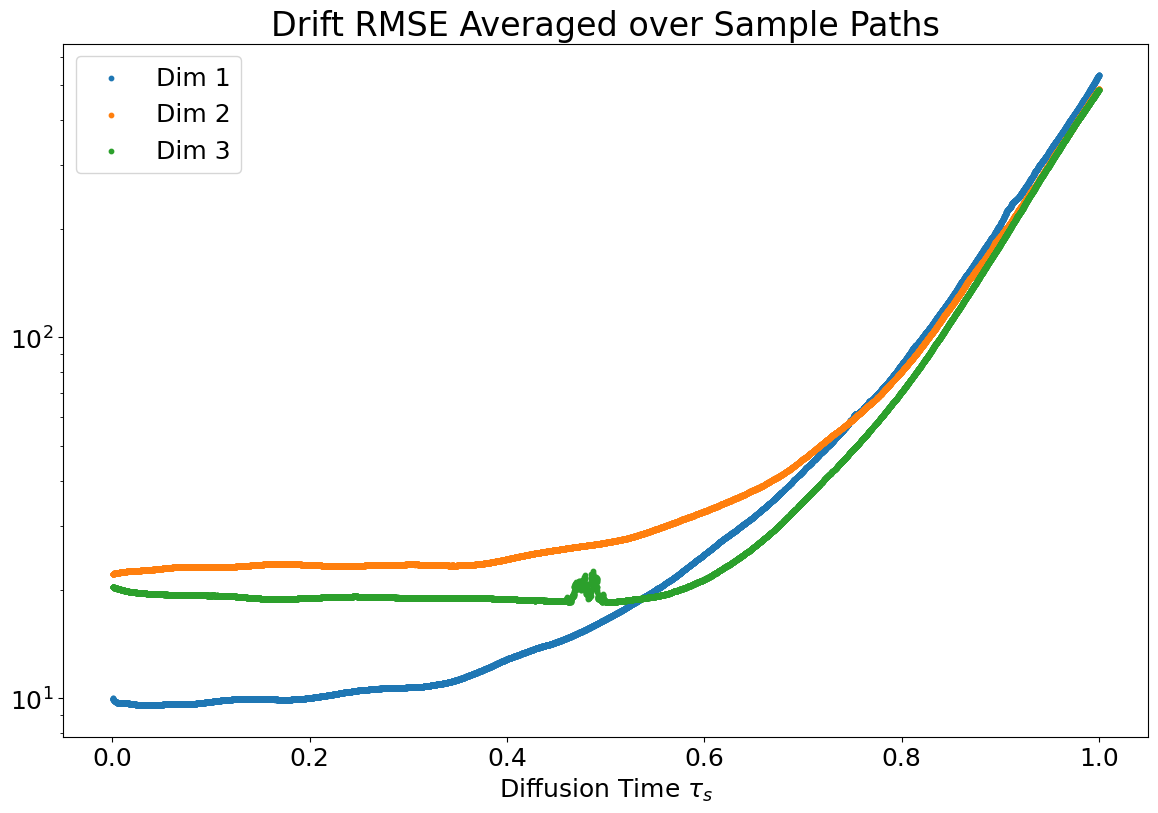

In [56]:
fig,ax= plt.subplots(figsize=(14,9))

# Normalize values for color mapping
for dim_idx, ref in zip([0,1,2],[true_mu0, true_mu1, true_mu2]):
    ref = ref.double()
    ref = ref.view(1, ref.shape[0], 1)
    avg_rel_error = torch.sqrt(torch.pow(ref - drift_est[:,1:,:,dim_idx].double(),2).mean(dim=(0,1)))
    plt.scatter(np.linspace(config.sample_eps, 1+1/Ndiff, Ndiff), avg_rel_error, s=10, label=f"Dim {dim_idx+1}")
    plt.yscale("log")
    print(f"Minimum RMSE at Dim {dim_idx+1}: {torch.min(avg_rel_error)}")
plt.xlabel("Diffusion Time $\\tau_{s}$", fontsize=18)
plt.title("Drift RMSE Averaged over Sample Paths", fontsize=24)
ax.tick_params(labelsize=18)
plt.legend(fontsize=18)
plt.show()
plt.close()

In [38]:
estimator = drift_est[:,1:,:2000,:].double().mean(dim=(0,2))
estimator_std = drift_est[:,1:,:2000,:].double().std(dim=(0,2))

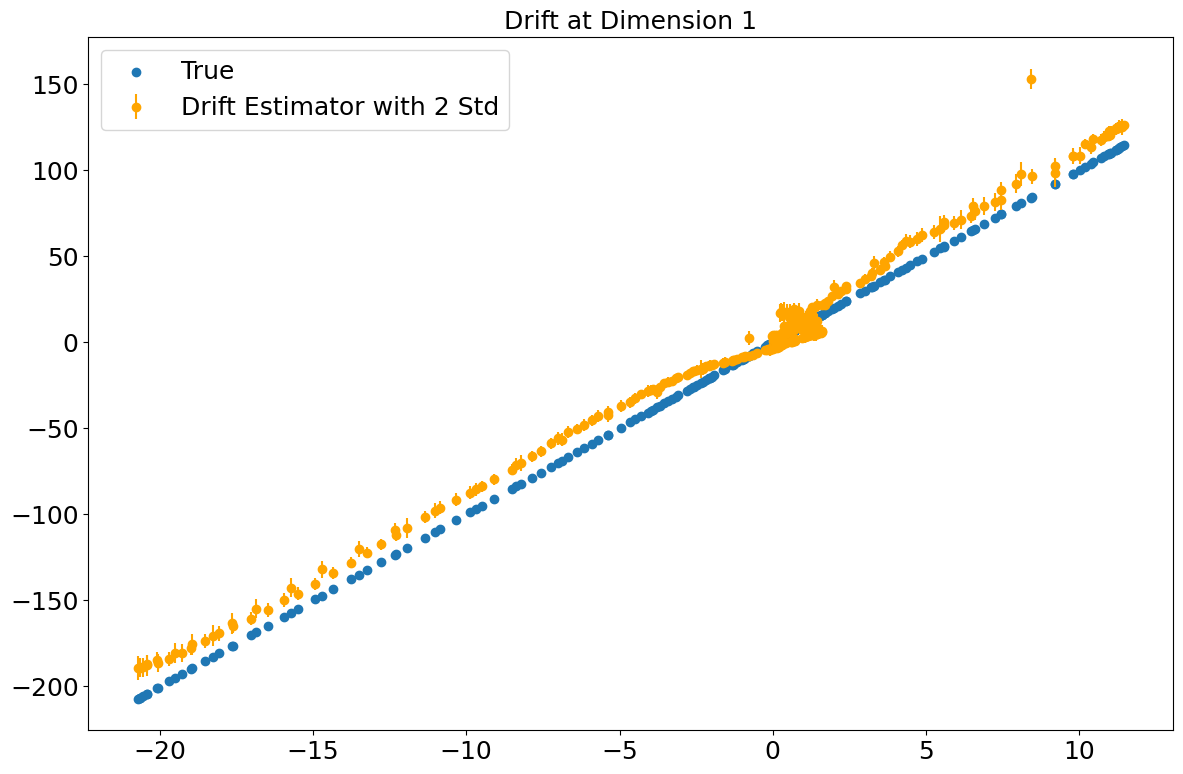

In [43]:
fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(y-x, true_drift[:,0], label="True")
plt.errorbar(y-x, estimator[:,0], fmt="o", color="orange",yerr=2*estimator_std[:,0], label="Drift Estimator with 2 Std")
plt.legend(fontsize=18)
ax.tick_params(labelsize=18)
plt.title("Drift at Dimension 1", fontsize=18)
plt.show()
plt.close()

In [30]:
raise RuntimeError

RuntimeError: 

In [ ]:
from matplotlib.colors import Normalize
from matplotlib import cm
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, projection='3d')
# Normalize values for color mapping
ref = true_mu0.double()[1:]
dim_idx = 0
estimator = drift_est[:,1:,-1000:,dim_idx].double().mean(dim=(0,2))
print(estimator.shape, ref.shape)
avg_rel_error = ((torch.abs(ref - estimator))/(ref.abs()))
# Normalize values for color mapping
norm = Normalize(vmin=torch.min(avg_rel_error), vmax=torch.max(avg_rel_error))
colors = cm.viridis(norm(avg_rel_error))  # Choose a colormap, e.g., viridis

# Scatter plot with colors representing the function values
ax.scatter(x[1:], y[1:], ref)
ax.scatter(x[1:], y[1:], estimator)

# Add a colorbar to show function values
#cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
#cbar.set_label('Absolute Errors for Dim 0')

In [ ]:
from matplotlib.colors import Normalize
from matplotlib import cm
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, projection='3d')
# Normalize values for color mapping
ref = true_mu0.double()[1:]
dim_idx = 0
estimator = drift_est[:,1:,-1000:,dim_idx].double().mean(dim=(0,2))
avg_rel_error = ((torch.abs(ref - estimator)))#/(ref.abs()))
# Normalize values for color mapping
norm = Normalize(vmin=torch.min(avg_rel_error), vmax=torch.max(avg_rel_error))
colors = cm.viridis(norm(avg_rel_error))  # Choose a colormap, e.g., viridis

# Scatter plot with colors representing the function values
scatter=ax.scatter(x[1:], y[1:], z[1:], c=avg_rel_error, marker="o")
# Add a colorbar to show function values
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Absolute Errors for Dim 0')

In [ ]:
from matplotlib.colors import Normalize
from matplotlib import cm
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, projection='3d')

estimator = drift_est[:,1:,10:1000,:].double().mean(dim=(0,2))
# Normalize the vectors (estimate and true drift) to have unit length
estimator_norm = estimator / estimator.norm(dim=1, keepdim=True)
true_drift_norm = true_drift / true_drift.norm(dim=1, keepdim=True)

# Plot the normalized estimated vector field (blue)
ax.quiver(x, y, z, estimator_norm[:, 0], estimator_norm[:, 1], estimator_norm[:, 2],
          length=0.1, color="b", label="Estimated", normalize=True)

# Plot the normalized true vector field (red)
ax.quiver(x, y, z, true_drift_norm[:, 0], true_drift_norm[:, 1], true_drift_norm[:, 2],
          length=0.1, color="r", label="True", normalize=True)

# Optional: Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Vector Field')
ax.view_init(elev=0, azim=90)  # You can also try elev=-90, azim=0

plt.show()